In [1]:
"""This module implements the Fréchet regression method from Petersen and Müller 2019.

The method is implemented in the context of estimation in the space of distribution
functions. Also, a simulation study is designed to compare with the methods outlined in
Petersen and Müller 2016.

"""

'This module implements the Fréchet regression method from Petersen and Müller 2019.\n\nThe method is implemented in the context of estimation in the space of distribution\nfunctions. Also, a simulation study is designed to compare with the methods outlined in\nPetersen and Müller 2016.\n\n'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import quadprog
from scipy.stats import norm

from frechet_fda.function_class import Function
from frechet_fda.tools.data_generation_tools import gen_params_regression, gen_y_qf
from frechet_fda.tools.frechet_tools import solve_frechet_qp
from frechet_fda.tools.function_tools import mean_func

In [3]:
N = 200
seed = 28071995
predictor_bounds = (-1, 1)
mu_params_dict = {
    "mu0" : 0,
    "beta" : 3,
    "v1" : 0.25
}
sigma_params_dict = {
    "sigma0" : 3,
    "gamma" : 0.5,
    "v2" : 2
}

In [4]:
predictor_vals, mus, sigmas = gen_params_regression(
    mu_params_dict, sigma_params_dict, N, predictor_bounds
)
predictor_vals.shape, mus.shape, sigmas.shape

((200,), (200,), (200,))

In [5]:
# Define u grid on which to evaluate function points
grid_size = 500
delta = 0 # can start bounded away from zero and one
u = np.linspace(delta, 1 - delta, grid_size)

In [6]:
qfs = gen_y_qf(mus, sigmas, u)

In [7]:
qfs[0].y.shape

(500,)

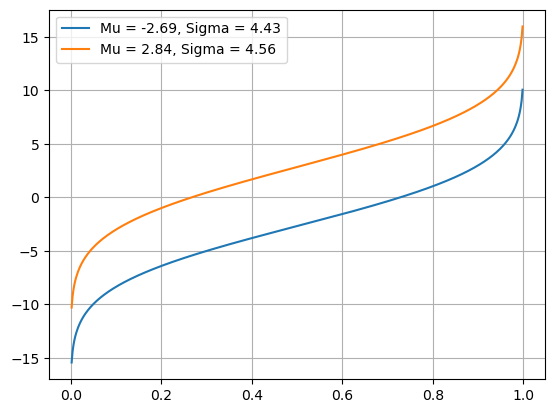

In [8]:
# Select which qfs to compare
first_qf_to_compare = 0
second_qf_to_compare = 199

qfs[first_qf_to_compare].compare(
    qfs[second_qf_to_compare],
    label_self=(
        f"Mu = {round(mus[first_qf_to_compare], 2)}, "
        f"Sigma = {round(sigmas[first_qf_to_compare], 2)}"
    ),
    label_other=(
        f"Mu = {round(mus[second_qf_to_compare], 2)}, "
        f"Sigma = {round(sigmas[second_qf_to_compare], 2)}"
    )
)

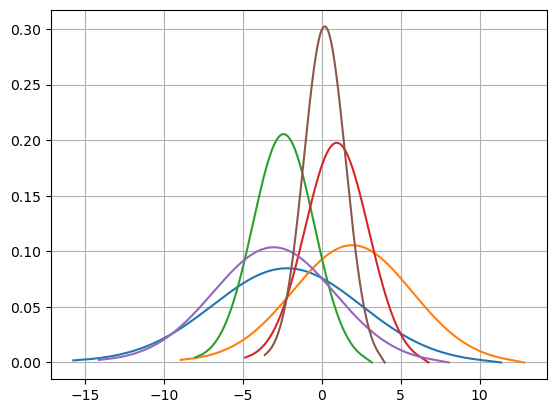

In [9]:
# Plot some densities of the generated distributions
fig, ax = plt.subplots()
some_qfs = np.random.default_rng().choice(qfs, size=6, replace=False)
for qf in some_qfs:
    pdf = qf.invert().differentiate()
    ax.plot(
        pdf.x,
        pdf.y,
    )
plt.grid()
plt.show()

In [10]:
# Take only every tenth value of predictor grid to calculate estimate
x_grid = predictor_vals[::10]
x_grid.shape

(20,)

In [11]:
estimates = solve_frechet_qp(x_grid, predictor_vals, qfs)

C:\Coding\thesis_frechet_fda\src\frechet_fda\function_class.py:219: RuntimeWarning: invalid value encountered in add
  comb_y = np.interp(comb_x, x, y) + np.interp(comb_x, val.x, val.y)


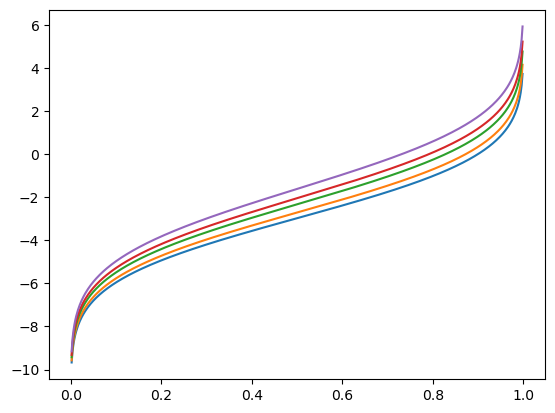

In [12]:
for func in estimates[:5]:
    plt.plot(func.x, func.y)

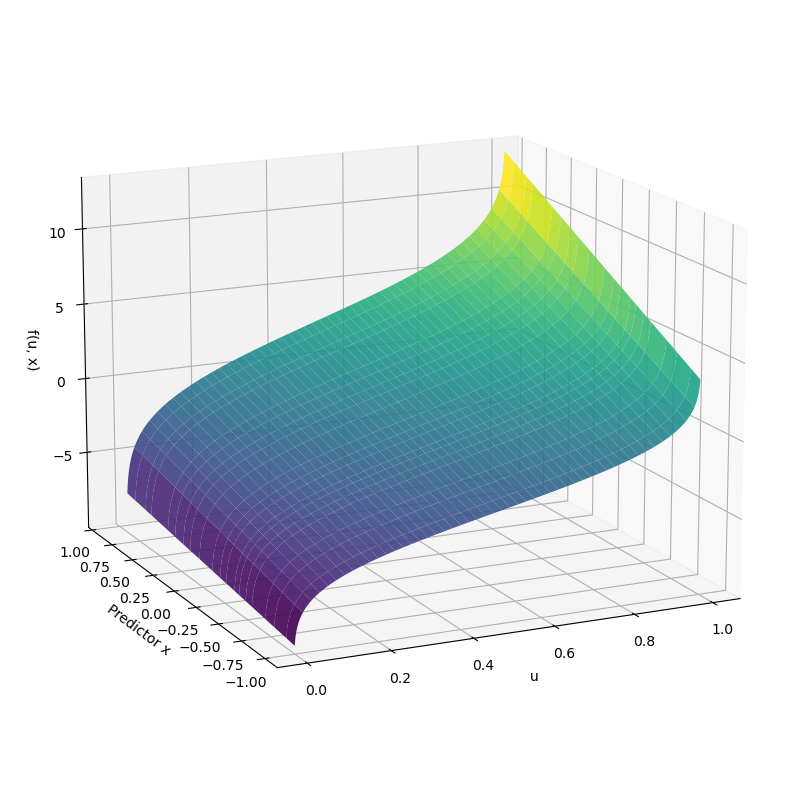

In [25]:
# Initialize a 2D array to hold f(u, x) values
z_values = np.zeros((len(x_grid), len(estimates[0].x)))

# Populate the array with estimates
for i, func in enumerate(estimates):
    z_values[i] = func.y

# Create the 3D surface plot
X, Y = np.meshgrid(estimates[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, z_values, cmap="viridis", alpha=0.9)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=245)

ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("f(u, x)", rotation=0)
plt.tight_layout()
plt.show()

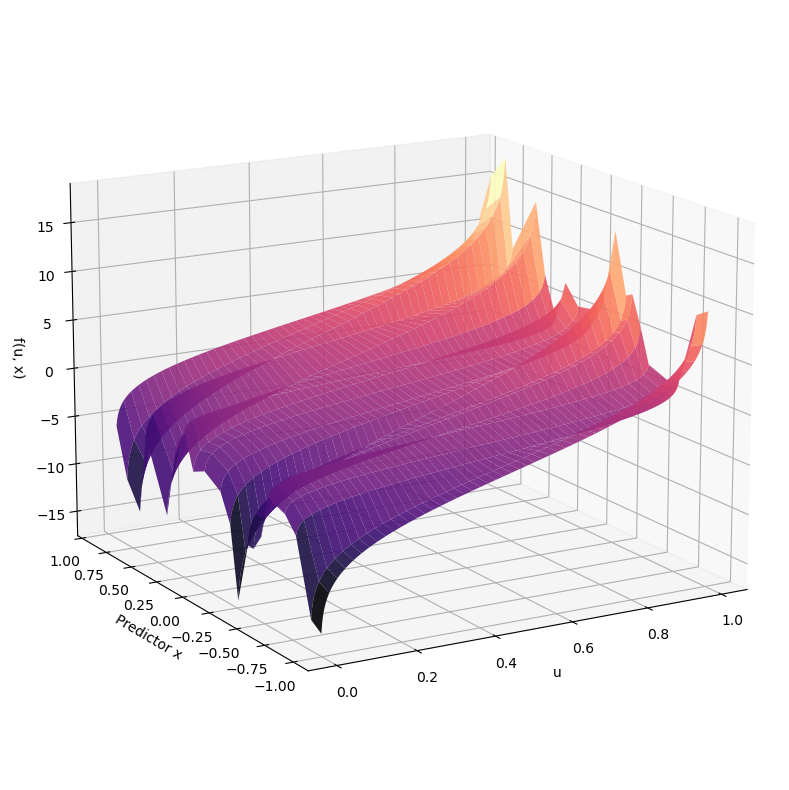

In [26]:
# New z_values for 'qfs'
qfs_of_interest = qfs[::10]
qfs_of_interest = [qf.drop_inf() for qf in qfs_of_interest]
z_values_qfs = np.zeros((len(x_grid), len(qfs_of_interest[0].x)))
for i, func in enumerate(qfs_of_interest):
    z_values_qfs[i] = func.y

# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(qfs_of_interest[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, z_values_qfs, cmap="magma", alpha=0.9)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=240)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("f(u, x)", rotation=0)

plt.tight_layout()
plt.show()

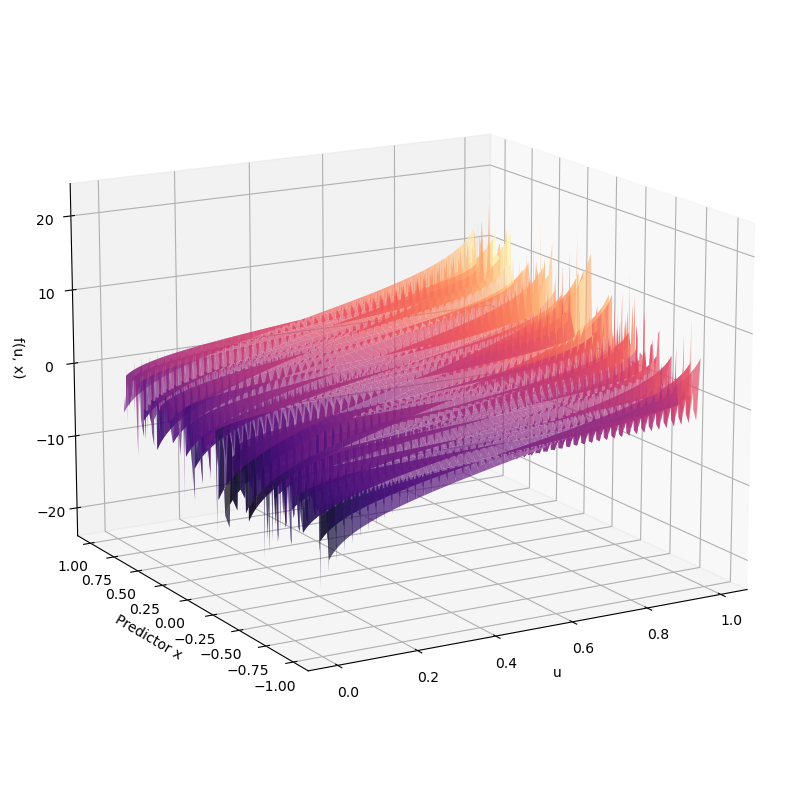

In [28]:
z_values_qfs = np.zeros((len(predictor_vals), len(qfs[0].x)))
for i, func in enumerate(qfs):
    z_values_qfs[i] = func.y

# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(qfs[0].x, predictor_vals)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, z_values_qfs, cmap="magma", alpha=0.7)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=240)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("f(u, x)", rotation=0)

plt.tight_layout()
plt.show()

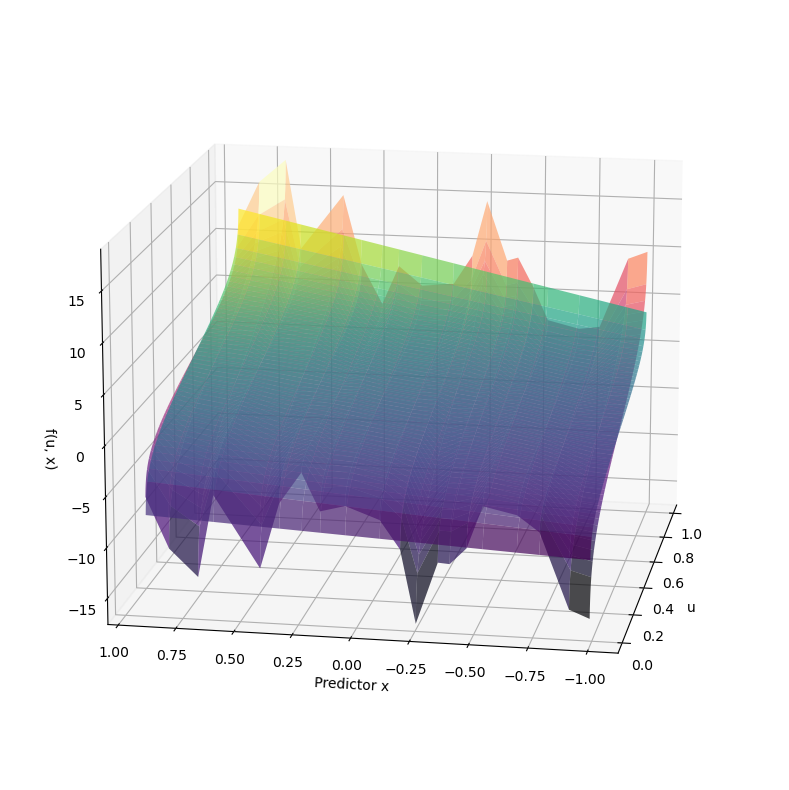

In [15]:
# Your existing setup and z_values calculation for 'estimates'
# ...

# New z_values for 'qfs'
qfs_of_interest = qfs[::10]
qfs_of_interest = [qf.drop_inf() for qf in qfs_of_interest]
z_values_qfs = np.zeros((len(x_grid), len(qfs_of_interest[0].x)))
for i, func in enumerate(qfs_of_interest):
    z_values_qfs[i] = func.y

# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(qfs_of_interest[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, z_values, cmap="viridis", alpha=0.7)

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, z_values_qfs, cmap="magma", alpha=0.7)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=190)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("f(u, x)", rotation=0)

plt.tight_layout()
plt.show()


### Compute Integrated Squared Error

In [52]:
from frechet_fda.tools.function_tools import quantile_distance

In [53]:
m_hat = estimates

In [54]:
true_m = qfs[::10]
true_m = [qf.drop_inf() for qf in true_m]

In [55]:
differences = [hat - true for hat, true in zip(m_hat, true_m, strict=True)]

In [56]:
distances = [
    quantile_distance(hat, true, already_qf=True)
    for hat, true in zip(m_hat, true_m, strict=True)
]

In [60]:
def ise_wasserstein(
        m_hat : list[Function],
        true_m : list[Function],
        x_to_predict : np.ndarray
    ) -> float:
    """Compute integrated squared error."""
    distances = [
        quantile_distance(hat, true, already_qf=True)
        for hat, true in zip(m_hat, true_m, strict=True)
    ]
    return Function(x_to_predict, distances).integrate().y[-1]

In [61]:
ise_wasserstein(m_hat, true_m, x_grid)

3.6030349817971272

## Functional Regression with Transformation method

In [ ]:
from frechet_fda.tools.function_tools import (
    inverse_log_qd_transform,
    log_qd_transform,
)

In [ ]:
mus[:5], sigmas[:5]

In [ ]:
# see whether toying around with function and returning to it changes anything
qfs[199].drop_inf().differentiate().integrate().compare(qfs[199].drop_inf() + 0.1)

In [ ]:
pdfs = [qf.drop_inf().invert().differentiate() for qf in qfs]
pdfs_normalized = [pdf.standardize_support() for pdf in pdfs]
lqdfs_and_start_vals = log_qd_transform(pdfs, different_supports=True)
lqdfs = lqdfs_and_start_vals[:, 0]
start_vals = lqdfs_and_start_vals[:, 1]

In [ ]:
predictor_matrix = np.array((np.ones(len(predictor_vals)), predictor_vals)).transpose()
predictor_matrix.shape, np.linalg.inv(
    predictor_matrix.transpose() @ predictor_matrix,
).shape

In [ ]:
log_betahat = (
    np.linalg.inv(predictor_matrix.transpose() @ predictor_matrix)
    @ predictor_matrix.transpose()
    @ lqdfs
)
log_betahat0 = log_betahat[0]
log_betahat1 = log_betahat[1]
log_betahat0.compare(log_betahat1)

In [ ]:
lqdf_hat = predictor_vals * log_betahat1 + log_betahat0
lqdfs[0].compare(lqdf_hat[0])
lqdfs[199].compare(lqdf_hat[199])
pdf_hat = inverse_log_qd_transform(lqdf_hat, start_vals)
pdfs[0].compare(pdf_hat[0])
pdfs[199].compare(pdf_hat[199])

In [ ]:
mus[0], mus[99], mus[199], sigmas[0], sigmas[99], sigmas[199]

In [ ]:
distribution_of_interest = 180
pdfs[distribution_of_interest].compare(pdf_hat[distribution_of_interest])
qfs[distribution_of_interest].compare(
    pdf_hat[distribution_of_interest].integrate().invert(),
)

In [ ]:
# Number of simulations
m = 5
# Number of samples of densities to generate
sample_sizes = [200]
# Number of sample points to generate from each density for density estimation step
points_number = 100
# Bandwidth choice for density estimation
bandwidth_choice = 0.2
# Fineness of grids to evaluate functions
grid_size = 1000
# Where to truncate normal distribution
trunc = 3
#
threshold_variance_explained = 0.9
# Initialize arrays to store Fréchet and cross sectional means
stored_f_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_f_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")

In [ ]:
total_iterations = m * len(sample_sizes)  # Total iterations
current_iteration = 0  # Initialize a counter for the current iteration
print("Simulating...", end="\r")
for i in range(m):
    # Try different sample sizes
    for j, n in enumerate(sample_sizes):
        # j index only used for storing Fréchet means below!
        # Set parameters
        seed_num = int(str(i) + str(j))  # unique seed in each simulation run
        mus, sigmas = gen_params_scenario_one(n, seed=seed_num)
        # Sort sigmas just for inspection reasons
        sigmas.sort()

        # Generate pdfs within truncation points
        pdfs = make_truncnorm_pdf(
            -trunc,
            trunc,
            mus,
            sigmas,
            grid_size=grid_size,
            warn_irregular_densities=False,
        )
        # Make Function class objects
        my_pdfs = make_function_objects(pdfs)

        # For numerical correction: shorten the range for smaller sigmas to get rid of
        # numerical artifacts when computing integrals, derivatives and means later
        new_ranges = get_optimal_range(my_pdfs)
        # Generate pdfs again, this time within individual ranges
        pdfs2 = [
            make_truncnorm_pdf(
                new_ranges[i][0],
                new_ranges[i][1],
                mus[i],
                sigmas[i],
                grid_size=grid_size,
                warn_irregular_densities=False,
            )[0]
            for i in range(n)
        ]

        # Generate numerically stable objects
        new_pdfs = make_function_objects(pdfs2)

        # Compute Fréchet mean
        stored_f_means[i, j] = frechet_mean(new_pdfs)
        stored_cs_means[i, j] = mean_func(new_pdfs)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(stored_f_means[i, j], new_pdfs)

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdfs)
        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least threshold_variance_explained
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdfs,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )

        ### And now again with additional density estimation step!
        which_kernel = "std_normal"
        sample_points = gen_truncnorm_pdf_points(
            -trunc,
            trunc,
            mus,
            sigmas,
            points_number,
        )
        pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=-trunc * np.ones(n),
            b=trunc * np.ones(n),
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        new_ranges = get_optimal_range(pdf_hats)
        # Generate numerically stable objects, within individual ranges
        new_pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=new_ranges[:, 0],
            b=new_ranges[:, 1],
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        # Compute Fréchet mean
        stored_f_means_denstimation[i, j] = frechet_mean(new_pdf_hats)
        stored_cs_means_denstimation[i, j] = mean_func(new_pdf_hats)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(
            stored_f_means_denstimation[i, j],
            new_pdf_hats,
        )

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdf_hats)

        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least threshold_variance_explained
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdf_hats,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )

        # Print progress of simulation
        current_iteration += 1  # Increment the current iteration
        perc = int(100 * current_iteration / total_iterations)
        print(f"Simulating...{perc}%", end="\r")